In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import load_model
from pickle import load
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse




def extract_features(filename, model):
        try:
            image = Image.open(filename)
            
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
 for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
 return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step



start the man is walking along the beach end


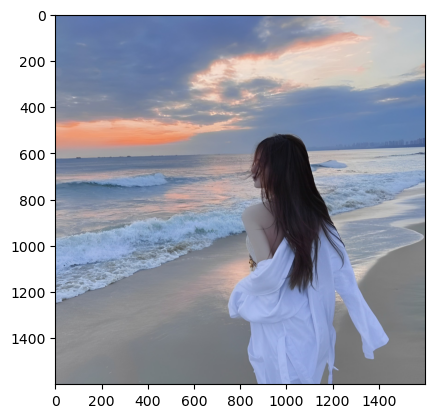

In [49]:

img_path = r"C:\Users\MY PC\Desktop\python-project-image-caption-generator\test_ảnh.jpg"

#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5', compile=False)
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [3]:
from nltk.translate.bleu_score import corpus_bleu

In [22]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

In [53]:
# 1. Load mô tả test từ file (Flickr8k_text/Flickr8k.token.txt)
def load_descriptions(filename, dataset_images):
    descriptions = {}
    with open(filename, 'r') as f:
        for line in f:
            tokens = line.strip().split()
            if not tokens: continue
            image_id_full, image_desc = tokens[0], tokens[1:]
            image_id = image_id_full.split('.')[0]  # ảnh dạng "1000268201_693b08cb0e.jpg#0"
            if image_id in dataset_images:
                if image_id not in descriptions:
                    descriptions[image_id] = []
                descriptions[image_id].append('startseq ' + ' '.join(image_desc) + ' endseq')
                print(f"Matched {image_id}")  # print ID nào được thêm vào
    return descriptions


# 2. Load danh sách ảnh test từ file Flickr8k.testImages.txt
def load_set(filename):
    with open(filename, 'r') as file:
        dataset = file.read().strip().split('\n')
    dataset = set([line.split('.')[0] for line in dataset])
    return dataset

# 3. Chuẩn bị actual và predicted captions
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    smoothie = SmoothingFunction().method4
    for key, desc_list in descriptions.items():
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        references = [d.split()[1:-1] for d in desc_list if len(d.split()) > 2]  # loại bỏ startseq/endseq và lọc câu quá ngắn
        yhat_tokens = yhat.split()
        if len(yhat_tokens) == 0 or len(references) == 0:
            # Bỏ qua cặp nếu dự đoán hoặc tham chiếu rỗng
            continue
        actual.append(references)
        predicted.append(yhat_tokens)
    
    if len(actual) == 0 or len(predicted) == 0:
        print("Không có cặp dữ liệu hợp lệ để tính BLEU.")
        return
    
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smoothie))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0), smoothing_function=smoothie))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie))

# 4. Load tập test ảnh (vector đặc trưng) từ thư mục (bạn đã extract trước)
def load_photo_features(filename, dataset):
    import pickle
    with open(filename, 'rb') as file:
        all_features = pickle.load(file)
    features = {k: all_features[k] for k in dataset if k in all_features}
    return features



In [50]:
# Load tập ảnh test
dataset_images = load_set(r'Flickr8k_text\Flickr_8k.testImages.txt')

# Load mô tả test, chỉ lấy các mô tả thuộc tập ảnh test
test_descriptions = load_descriptions(r'Flickr8k_text\Flickr8k.token.txt', dataset_images)

# Load feature ảnh test (đã extract trước)
test_features = load_photo_features(r'features.p', dataset_images)

# Lọc test_descriptions chỉ giữ key có trong test_features để tránh KeyError
test_descriptions = {k: v for k, v in test_descriptions.items() if k in test_features}

# Đánh giá mô hình
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)


Không có cặp dữ liệu hợp lệ để tính BLEU.


In [ ]:
/
/
/
/
/
/
/
/
/
/
/
/
/


In [10]:
import os

In [11]:
print(os.getcwd())


C:\Users\MY PC\Desktop\python-project-image-caption-generator


In [52]:
print(f"dataset_images is empty: {len(dataset_images) == 0}")
print(f"test_descriptions is empty: {len(test_descriptions) == 0}")
print(f"test_features is empty: {len(test_features) == 0}")

# In thêm một số key để kiểm tra
print("Some dataset_images:", list(dataset_images)[:5])
print("Some test_descriptions keys:", list(test_descriptions.keys())[:5])
print("Some test_features keys:", list(test_features.keys())[:5])


dataset_images is empty: False
test_descriptions is empty: True
test_features is empty: True
Some dataset_images: ['1554713437_61b64527dd', '2884420269_225d27f242', '370614351_98b8a166b9', '2886411666_72d8b12ce4', '3203453897_6317aac6ff']
Some test_descriptions keys: []
Some test_features keys: []


In [41]:
import pickle

In [42]:
with open('features.p', 'rb') as f:
    all_features = pickle.load(f)

print(f"Tổng số feature: {len(all_features)}")
print("Một vài key:", list(all_features.keys())[:5])

Tổng số feature: 8091
Một vài key: ['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg', '1003163366_44323f5815.jpg', '1007129816_e794419615.jpg']


In [43]:
missing = [id for id in dataset_images if id not in all_features]
print(f"Số ảnh test không có feature: {len(missing)}")
print("Một vài ID không có feature:", missing[:5])

Số ảnh test không có feature: 1000
Một vài ID không có feature: ['1554713437_61b64527dd', '2884420269_225d27f242', '370614351_98b8a166b9', '2886411666_72d8b12ce4', '3203453897_6317aac6ff']


In [44]:
# Load test image IDs
with open(r'Flickr8k_text\Flickr_8k.testImages.txt', 'r') as f:
    test_lines = [line.strip().split('.')[0] for line in f.readlines()]
print(f"Số test image ID: {len(test_lines)}")
print("Một vài test image ID:", test_lines[:5])

# So sánh với các ID trong token file
with open(r'Flickr8k_text\Flickr8k.token.txt', 'r') as f:
    token_lines = f.readlines()

token_ids = set(line.split()[0].split('.')[0] for line in token_lines)
print(f"Số ID trong token file: {len(token_ids)}")

# Giao giữa 2 tập
intersect = set(test_lines) & token_ids
print(f"Số ID trùng nhau: {len(intersect)}")
print("Một vài ID trùng:", list(intersect)[:5])


Số test image ID: 1000
Một vài test image ID: ['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01']
Số ID trong token file: 8092
Số ID trùng nhau: 1000
Một vài ID trùng: ['2884420269_225d27f242', '1554713437_61b64527dd', '2886411666_72d8b12ce4', '370614351_98b8a166b9', '3203453897_6317aac6ff']


In [48]:
with open('features.p', 'rb') as f:
    features = pickle.load(f)

print("Tổng số ảnh trong features.p:", len(features))
print("Một vài key (ID) trong features.p:", list(features.keys())[:10])

# So sánh với test ID
intersect = set(dataset_images) & set(features.keys())
print("Số test ID có trong features.p:", len(intersect))
print("Ví dụ key trùng:", list(intersect)[:5])


Tổng số ảnh trong features.p: 8091
Một vài key (ID) trong features.p: ['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg', '1003163366_44323f5815.jpg', '1007129816_e794419615.jpg', '1007320043_627395c3d8.jpg', '1009434119_febe49276a.jpg', '1012212859_01547e3f17.jpg', '1015118661_980735411b.jpg', '1015584366_dfcec3c85a.jpg']
Số test ID có trong features.p: 0
Ví dụ key trùng: []


In [54]:
dataset_images = load_set(r'Flickr8k_text\Flickr_8k.testImages.txt')
print("Loaded dataset_images:", len(dataset_images), "IDs e.g.", list(dataset_images)[:5])
test_descriptions = load_descriptions(r'Flickr8k_text\Flickr8k.token.txt', dataset_images)
print("Loaded test_descriptions:", len(test_descriptions))

Loaded dataset_images: 1000 IDs e.g. ['1554713437_61b64527dd', '2884420269_225d27f242', '370614351_98b8a166b9', '2886411666_72d8b12ce4', '3203453897_6317aac6ff']
Matched 1056338697_4f7d7ce270
Matched 1056338697_4f7d7ce270
Matched 1056338697_4f7d7ce270
Matched 1056338697_4f7d7ce270
Matched 1056338697_4f7d7ce270
Matched 106490881_5a2dd9b7bd
Matched 106490881_5a2dd9b7bd
Matched 106490881_5a2dd9b7bd
Matched 106490881_5a2dd9b7bd
Matched 106490881_5a2dd9b7bd
Matched 1082379191_ec1e53f996
Matched 1082379191_ec1e53f996
Matched 1082379191_ec1e53f996
Matched 1082379191_ec1e53f996
Matched 1082379191_ec1e53f996
Matched 1084040636_97d9633581
Matched 1084040636_97d9633581
Matched 1084040636_97d9633581
Matched 1084040636_97d9633581
Matched 1084040636_97d9633581
Matched 1096395242_fc69f0ae5a
Matched 1096395242_fc69f0ae5a
Matched 1096395242_fc69f0ae5a
Matched 1096395242_fc69f0ae5a
Matched 1096395242_fc69f0ae5a
Matched 1107246521_d16a476380
Matched 1107246521_d16a476380
Matched 1107246521_d16a476380
Mat

In [55]:
with open('features.p', 'rb') as f:
    all_features = pickle.load(f)

# Chuẩn hóa key (loại bỏ .jpg) và lọc chỉ những ID thuộc dataset_images
test_features = {k.split('.')[0]: v for k, v in all_features.items() if k.split('.')[0] in dataset_images}

print(f"Số ảnh test có feature: {len(test_features)}")  # kỳ vọng là 1000

# Rồi gọi hàm evaluate_model đã sửa (dùng SmoothingFunction và bỏ các cặp rỗng)
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Số ảnh test có feature: 1000
BLEU-1: 0.353161
BLEU-2: 0.189163
BLEU-3: 0.126831
BLEU-4: 0.054866
